# FloPy

Flopy has some limited support for working with unstructured grids.  This support is expected to improve as new capabilities are developed.  This notebook shows how to plot unstructured grids.  Grids are represented using a list of vertices and a vertex incidence list, which is just a list of the vertex numbers that comprise a cell.

In [1]:
# Set up the environment
import os
import sys
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy

from flopy.discretization import UnstructuredGrid
    
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

flopy is installed in /Users/jdhughes/Documents/Development/flopy_git/flopy_fork/flopy
3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 14:38:56) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.17.3
matplotlib version: 3.1.1
flopy version: 3.2.13


In [2]:
# This is a folder containing some unstructured grids
datapth = os.path.join('..', 'data', 'unstructured')

In [3]:
# Simple functions to load vertices and incidence lists
def load_verts(fname):
    return(np.genfromtxt(fname))

def load_iverts(fname):
    f = open(fname, 'r')
    iverts = []
    xc = []
    yc = []
    for line in f:
        ll = line.strip().split()
        iverts.append([int(i) - 1 for i in ll[4:]])
        xc.append(float(ll[1]))
        yc.append(float(ll[2]))
    return iverts, np.array(xc), np.array(yc)

In [4]:
# load vertices
fname = os.path.join(datapth, 'ugrid_verts.dat')
verts = load_verts(fname)[:, 1:]

# load the incidence list into iverts
fname = os.path.join(datapth, 'ugrid_iverts.dat')
iverts, xc, yc = load_iverts(fname)

In this case, verts is just a 2-dimensional list of x,y vertex pairs.  iverts is also a 2-dimensional list, where the outer list is of size ncells, and the inner list is a list of the vertex numbers that comprise the cell.

In [5]:
# Print the first 5 entries in verts and iverts
for ivert, v in enumerate(verts[:5]):
    print('Vertex coordinate pair for vertex {}: {}'.format(ivert, v))
print('...\n')
    
for icell, vertlist in enumerate(iverts[:5]):
    print('List of vertices for cell {}: {}'.format(icell, vertlist))

Vertex coordinate pair for vertex 0: [  0. 700.]
Vertex coordinate pair for vertex 1: [100. 700.]
Vertex coordinate pair for vertex 2: [100. 600.]
Vertex coordinate pair for vertex 3: [  0. 600.]
Vertex coordinate pair for vertex 4: [200. 700.]
...

List of vertices for cell 0: [0, 1, 2, 3, 0]
List of vertices for cell 1: [1, 4, 5, 2, 1]
List of vertices for cell 2: [4, 6, 7, 5, 4]
List of vertices for cell 3: [6, 8, 9, 7, 6]
List of vertices for cell 4: [8, 10, 11, 9, 8]


A flopy unstructured spatial reference object can now be created using the vertices and incidence list.  The spatial reference object is a key part of the plotting capabilities in flopy.  In addition to the vertex information, the spatial reference object also needs to know how many cells are in each layer.  This is specified in the ncpl variable, which is a list of cells per layer.

In [6]:
ncpl = np.array(5 * [len(iverts)])
umg = UnstructuredGrid(verts, iverts, xc, yc, ncpl=ncpl)
print(ncpl)
print(umg)

[218 218 218 218 218]
xll:0.0; yll:0.0; rotation:0.0; units:undefined; lenuni:0


Now that we have a spatial reference, we can use the flopy ModelMap object to create different types of plots, just like we do for structured grids.

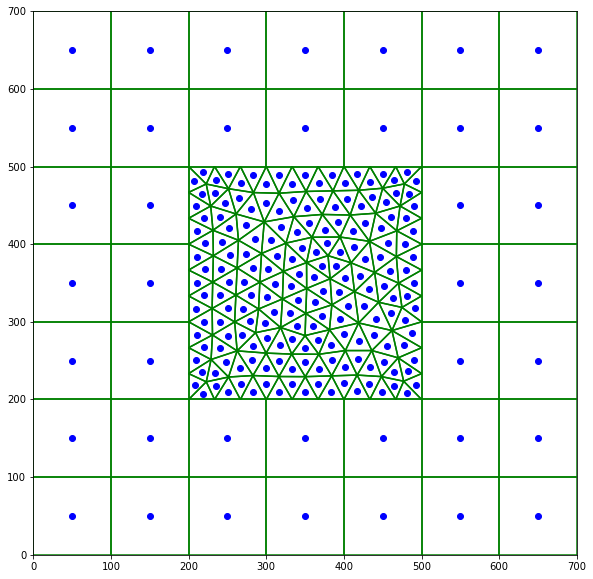

In [7]:
f = plt.figure(figsize=(10, 10))
pmv = flopy.plot.PlotMapView(modelgrid=umg)
pmv.plot_grid(colors='green')
plt.plot(umg.xcellcenters, umg.ycellcenters, 'bo');

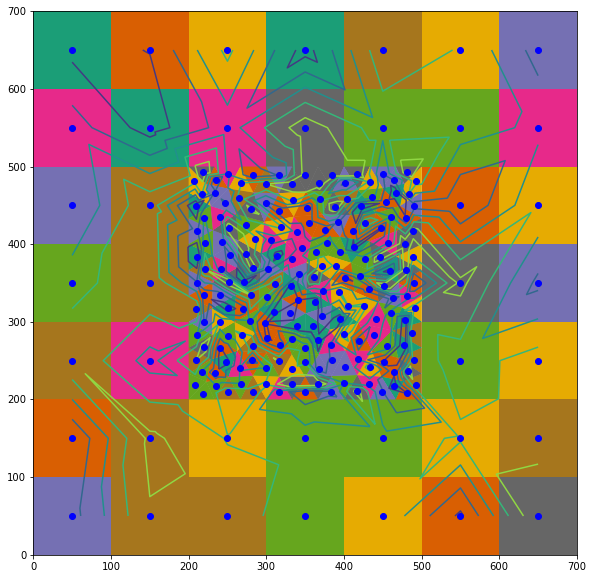

In [8]:
# Create a random array for layer 0, and then plot it with a color flood and contours
f = plt.figure(figsize=(10, 10))
a = np.random.random((ncpl[0]))
pmv = flopy.plot.PlotMapView(modelgrid=umg)
pmv.plot_array(a)
pmv.contour_array(a)
plt.plot(xc, yc, 'bo');

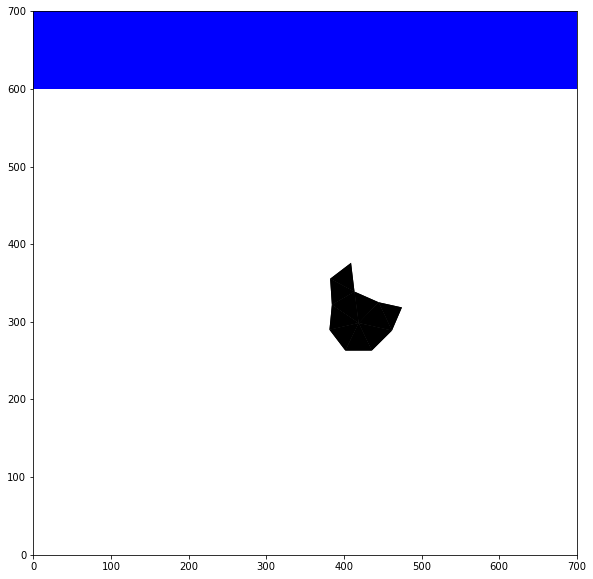

In [9]:
# The flopy ModelMap methods should also work on this.
f = plt.figure(figsize=(10, 10))
ibound = np.ones((ncpl[0]))
ibound[0:7] = -1
ibound[-10:] = 0
pmv = flopy.plot.PlotMapView(modelgrid=umg)
pmv.plot_ibound(ibound=ibound);

Here are some examples of some other types of grids.  The data files for these grids are located in the datapth folder.

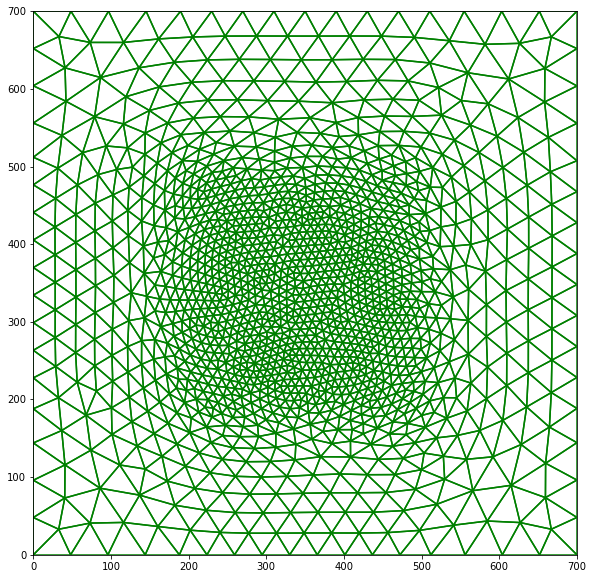

In [10]:
fname = os.path.join(datapth, 'TriMesh_local.exp')
f = plt.figure(figsize=(10, 10))
umg = UnstructuredGrid.from_argus_export(fname, nlay=1)
pmv= flopy.plot.PlotMapView(modelgrid=umg)
pmv.plot_grid(colors='green');

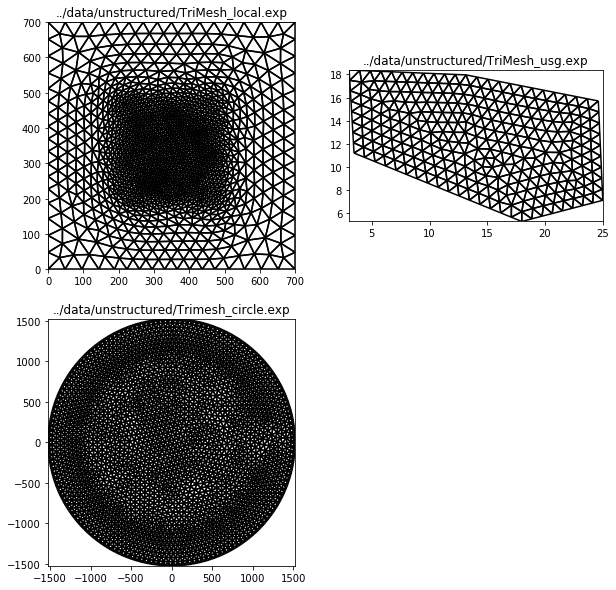

In [11]:
f = plt.figure(figsize=(10, 10))
fnames = [fname for fname in os.listdir(datapth) if fname.endswith('.exp')]
nplot = len(fnames)
for i, f in enumerate(fnames):
    ax = plt.subplot(nplot / 2 + 1, 2, i + 1, aspect='equal')
    fname = os.path.join(datapth, f)
    umg = UnstructuredGrid.from_argus_export(fname, nlay=1)
    pmv = flopy.plot.PlotMapView(modelgrid=umg, ax=ax)
    pmv.plot_grid(colors='k')
    ax.set_title(fname)